
## Spark

In [1]:
#@title  <-- Run Me: (Hidden) Installing Spark
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get -qq install -y openjdk-8-jdk-headless

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [2]:
#@title  <-- Run Me: (Hidden) Environment Variable Setup
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd    
import numpy as np


# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

## Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Read in data
TRAIN_DIR = "drive/MyDrive/STAT480/dataset/track2"

In [7]:
training = spark.read.option("header","false").option("delimiter","\t").csv(TRAIN_DIR+'/training.txt')
training = training.selectExpr('_c0 as Click', '_c1 as Impression', '_c2 as AdURL', '_c3 as AdId', '_c4 as AdvId', 
                    '_c5 as Depth', '_c6 as Pos', '_c7 as QId', '_c8 as KeyId', '_c9 as TitleId', 
                    '_c10 as DescId', '_c11 as UId')
training.show(10)

+-----+----------+--------------------+--------+-----+-----+---+--------+------+-------+-------+------+
|Click|Impression|               AdURL|    AdId|AdvId|Depth|Pos|     QId| KeyId|TitleId| DescId|   UId|
+-----+----------+--------------------+--------+-----+-----+---+--------+------+-------+-------+------+
|    0|         1| 4298118681424644510| 7686695|  385|    3|  3|    1601|  5521|   7709|    576|490234|
|    0|         1| 4860571499428580850|21560664|37484|    2|  2| 2255103|   317|  48989|  44771|490234|
|    0|         1| 9704320783495875564|21748480|36759|    3|  3| 4532751| 60721| 685038|  29681|490234|
|    0|         1|13677630321509009335| 3517124|23778|    3|  1|    1601|  2155|   1207|   1422|490234|
|    0|         1| 3284760244799604489|20758093|34535|    1|  1| 4532751| 77819| 266618| 222223|490234|
|    0|         1|10196385171799537224|21375650|36832|    2|  1| 4688625|202465| 457316| 429545|490234|
|    0|         1| 4203081172173603803| 4427028|28647|    3|  1|

In [8]:
userid = spark.read.option("header","false").option("delimiter","\t").csv(TRAIN_DIR+'/userid_profile.txt')
userid = userid.selectExpr('_c0 as UId', '_c1 as Gender', '_c2 as Age')
userid.show(10)

+---+------+---+
|UId|Gender|Age|
+---+------+---+
|  1|     1|  5|
|  2|     2|  3|
|  3|     1|  5|
|  4|     1|  3|
|  5|     2|  1|
|  6|     2|  3|
|  7|     2|  3|
|  8|     2|  4|
|  9|     1|  3|
| 10|     2|  5|
+---+------+---+
only showing top 10 rows



### Other tables

In [ ]:
"""
purchasekeywordid = spark.read.option("header","false").option("delimiter","\t").csv(TRAIN_DIR+'/purchasedkeywordid_tokensid.txt')
purchasekeywordid = purchasekeywordid.selectExpr('_c0 as KeyId', '_c1 as PurchaseKeyword')
purchasekeywordid.show(10)

"""

In [ ]:
"""
queryid = spark.read.option("header","false").option("delimiter","\t").csv(TRAIN_DIR+'/queryid_tokensid.txt')
queryid = queryid.selectExpr('_c0 as QId', '_c1 as Query')
queryid.show(10)

"""

In [ ]:
"""
descriptionid = spark.read.option("header","false").option("delimiter","\t").csv(TRAIN_DIR+'/descriptionid_tokensid.txt')
descriptionid = descriptionid.selectExpr('_c0 as DescId', '_c1 as Description')
descriptionid.show(10)

"""

In [ ]:
"""
titleid = spark.read.option("header","false").option("delimiter","\t").csv(TRAIN_DIR+'/titleid_tokensid.txt')
titleid = titleid.selectExpr('_c0 as TitleId', '_c1 as Titile')
titleid.show(10)

"""

## Data pre-processing

In [9]:
train_df = training.join(userid, on="UId", how="inner")
train_df.show(10)

+--------+-----+----------+--------------------+--------+-----+-----+---+--------+------+-------+-------+------+---+
|     UId|Click|Impression|               AdURL|    AdId|AdvId|Depth|Pos|     QId| KeyId|TitleId| DescId|Gender|Age|
+--------+-----+----------+--------------------+--------+-----+-----+---+--------+------+-------+-------+------+---+
|10000108|    1|         1|16004847651863108809|20580649|33712|    1|  1|   70637|433604|1873667|1447913|     1|  3|
|10000108|    0|         1| 5888277431783335848| 7955169| 6520|    2|  2|    1103|  1727|   1537|   2058|     1|  3|
|10000108|    0|         1| 6912851286990253226|20812538|18903|    2|  1|    1103|  1727|   8112|   9633|     1|  3|
|10000172|    0|         1|11121833691387078599|20885956|23807|    1|  1|     960|  3554|      5|     11|     2|  3|
|10000172|    0|         1|18054023944582974704|21156710|29479|    2|  1|     303|  1040|   1907|    878|     2|  3|
|10000172|    0|         1|15347157359829613284|10224435|23040| 

In [10]:
from pyspark.sql.types import IntegerType,StringType,DateType
from pyspark.sql.functions import col

train_df = train_df.withColumn("Click",train_df.Click.cast('int'))
train_df = train_df.withColumn("Impression",train_df.Impression.cast('int'))
train_df = train_df.withColumn("Depth",train_df.Depth.cast('int'))
train_df = train_df.withColumn("Gender",train_df.Gender.cast('int'))
train_df = train_df.withColumn("Age",train_df.Age.cast('int'))

In [17]:
from pyspark.ml.feature import VectorAssembler

train_assembler = VectorAssembler(inputCols=['Impression', 'Depth',
                         'Gender', 'Age',],
                 outputCol='features')
train_df = train_assembler.transform(train_df)

In [18]:
# split the dataset
dataset = train_df.select(['features', 'Click'])
data1, data2 = dataset.randomSplit([0.25, 0.75])
train, test = data1.randomSplit([0.8, 0.2])

## Random Forest

In [19]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='Click')
rf_model = rf.fit(train[(train.Click == 1) | (train.Click == 0)])

In [20]:
result_rf = rf_model.transform(test)
result_rf.show(5)

+-----------------+-----+--------------------+--------------------+----------+
|         features|Click|       rawPrediction|         probability|prediction|
+-----------------+-----+--------------------+--------------------+----------+
|[1.0,1.0,0.0,1.0]|    0|[19.0402212049664...|[0.95201106024832...|       0.0|
|[1.0,1.0,0.0,1.0]|    0|[19.0402212049664...|[0.95201106024832...|       0.0|
|[1.0,1.0,0.0,1.0]|    0|[19.0402212049664...|[0.95201106024832...|       0.0|
|[1.0,1.0,0.0,1.0]|    0|[19.0402212049664...|[0.95201106024832...|       0.0|
|[1.0,1.0,0.0,1.0]|    0|[19.0402212049664...|[0.95201106024832...|       0.0|
+-----------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



### Model Evaluation

In [21]:
tp_rf = result_rf[(result_rf.Click == 1) & (result_rf.prediction == 1)].count()
tn_rf = result_rf[(result_rf.Click == 0) & (result_rf.prediction == 0)].count()
fp_rf = result_rf[(result_rf.Click == 0) & (result_rf.prediction == 1)].count()
fn_rf = result_rf[(result_rf.Click == 1) & (result_rf.prediction == 0)].count()

print('tp is : %f'%(tp_rf))
print('tn is : %f'%(tn_rf))
print('fp is : %f'%(fp_rf))
print('fn is : %f'%(fn_rf))

tp is : 0.000000
tn is : 5273644.000000
fp is : 0.000000
fn is : 264990.000000


In [26]:
# Accuracy
print('test accuracy is : %f'%((tp_rf+tn_rf)/(tp_rf+tn_rf+fp_rf+fn_rf)))

# Recall
print('Recall is : %f'%(tp_rf/(tp_rf+fn_rf)))

# Precision
# print('test accuracy is : %f'%(tp_rf/(tp_rf+fp_rf)))
# division by zero

test accuracy is : 0.952156
Recall is : 0.000000


In [27]:
preds_rf = result_rf.select('Click','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Click']))).collect()

from sklearn.metrics import roc_curve
y_score, y_true = zip(*preds_rf)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)

Text(0, 0.5, 'True Positive Rate')

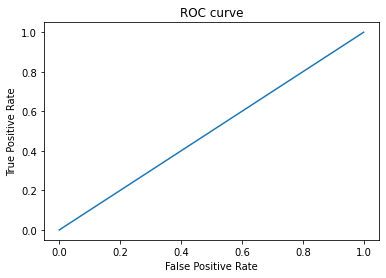

In [28]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Logistic Regression Model

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features_lr', labelCol = 'Click')
lr_model = lr.fit(train)

In [ ]:
result_lr = lr_model.transform(test)
result_lr.show(5)

+-----------------+-----+--------------------+--------------------+----------+
|         features|Click|       rawPrediction|         probability|prediction|
+-----------------+-----+--------------------+--------------------+----------+
|[1.0,1.0,1.0,1.0]|    0|[15.1604763407269...|[0.94559747260298...|       0.0|
|[1.0,1.0,1.0,1.0]|    0|[15.1604763407269...|[0.94559747260298...|       0.0|
|[1.0,1.0,1.0,1.0]|    0|[15.1604763407269...|[0.94559747260298...|       0.0|
|[1.0,1.0,1.0,1.0]|    0|[15.1604763407269...|[0.94559747260298...|       0.0|
|[1.0,1.0,1.0,1.0]|    0|[15.1604763407269...|[0.94559747260298...|       0.0|
+-----------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



### Model Evaluation

In [ ]:
tp_lr = result_lr[(result_lr.Click == 1) & (result_lr.prediction == 1)].count()
tn_lr = result_lr[(result_lr.Click == 0) & (result_lr.prediction == 0)].count()
fp_lr = result_lr[(result_lr.Click == 0) & (result_lr.prediction == 1)].count()
fn_lr = result_lr[(result_lr.Click == 1) & (result_lr.prediction == 0)].count()

print('tp is : %f'%(tp_lr))
print('tn is : %f'%(tn_lr))
print('fp is : %f'%(fp_lr))
print('fn is : %f'%(fn_lr))

tp is : 0.000000
tn is : 5275488.000000
fp is : 0.000000
fn is : 265754.000000


In [ ]:
# Accuracy
print('test accuracy is : %f'%((tp_lr+tn_lr)/(tp_lr+tn_lr+fp_lr+fn_lr)))

# Recall
print('Recall is : %f'%(tp_lr/(tp_lr+fn_lr)))

# Precision
# print('Precision is : %f'%(tp_lr/(tp_lr+fp_lr)))
# division by zero

test accuracy is : 0.952041
Recall accuracy is : 0.000000


In [ ]:
preds_lr = result_lr.select('Click','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Click']))).collect()

from sklearn.metrics import roc_curve
y_score, y_true = zip(*preds_lr)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)

Text(0, 0.5, 'True Positive Rate')

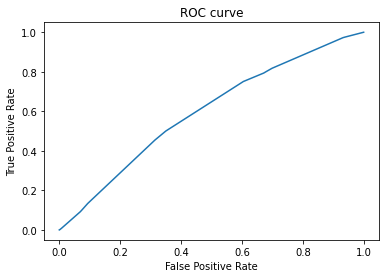

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Naive Bayes

In [ ]:
from pyspark.sql.types import IntegerType,StringType,DateType
from pyspark.sql.functions import col

training = training.withColumn("Click",training.Click.cast('int'))
training = training.withColumn("UId",training.UId.cast('int'))
training = training.withColumn("AdvId",training.AdvId.cast('int'))
training = training.withColumn("KeyId",training.KeyId.cast('int'))
training = training.withColumn("Pos",training.Pos.cast('int'))

In [ ]:
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.evaluation import BinaryClassificationEvaluator


train_nb_assembler = VectorAssembler(inputCols=['UId', 'AdvId',
                        'KeyId', 'Pos'],
                 outputCol='features')
train_nb_df = train_nb_assembler.transform(training)

In [ ]:
# split the dataset
dataset_nb = train_nb_df.select(['features', 'Click'])
data1_nb, data2_nb = dataset_nb.randomSplit([0.25, 0.75])
train_nb, test_nb = data1_nb.randomSplit([0.8, 0.2])

In [ ]:
nb = NaiveBayes(featuresCol = 'features', labelCol = 'Click')
nbmodel = nb.fit(train_nb)

In [ ]:
result_nb = nbmodel.transform(test_nb)
result_nb.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|Click|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[21.0,125.0,3734....|    0|[-18060.103602818...|[0.0,0.0,0.0,0.0,...|     241.0|
|[21.0,385.0,6154....|    0|[-30677.009339494...|[0.0,0.0,0.0,0.0,...|     241.0|
|[21.0,385.0,6154....|    0|[-30677.009339494...|[0.0,0.0,0.0,0.0,...|     241.0|
|[21.0,385.0,60852...|    0|[-285745.44204539...|[0.0,0.0,0.0,0.0,...|     241.0|
|[21.0,385.0,60852...|    0|[-285745.44204539...|[0.0,0.0,0.0,0.0,...|     241.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



### Model Evaluation

In [ ]:
tp_nb = result_nb[(result_nb.Click == 1) & (result_nb.prediction == 1)].count()
tn_nb = result_nb[(result_nb.Click == 0) & (result_nb.prediction == 0)].count()
fp_nb = result_nb[(result_nb.Click == 0) & (result_nb.prediction == 1)].count()
fn_nb = result_nb[(result_nb.Click == 1) & (result_nb.prediction == 0)].count()

print('tp is : %f'%(tp_nb))
print('tn is : %f'%(tn_nb))
print('fp is : %f'%(fp_nb))
print('fn is : %f'%(fn_nb))

tp is : 15620.000000
tn is : 58782.000000
fp is : 239266.000000
fn is : 3587.000000


In [ ]:
# Accuracy
print('test accuracy is : %f'%((tp_nb+tn_nb)/(tp_nb+tn_nb+fp_nb+fn_nb)))

# Recall
print('Recall is : %f'%(tp_nb/(tp_nb+fn_nb)))

# Precision
print('Precision is : %f'%(tp_nb/(tp_nb+fp_nb)))

test accuracy is : 0.234518
Recall is : 0.813245
Precision is : 0.061282


In [ ]:
preds_nb = result_nb.select('Click','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Click']))).collect()

from sklearn.metrics import roc_curve
y_score, y_true = zip(*preds_nb)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)

Text(0, 0.5, 'True Positive Rate')

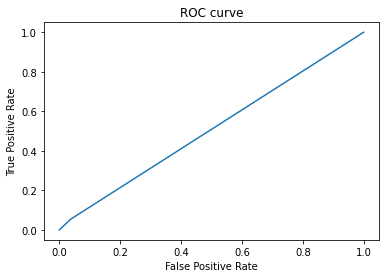

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')